# 07. Model CNN - Keras Tuner

### Importando as bibliotecas

In [1]:
import sys
import os
from pathlib import Path
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

### Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Configurando para serem exibidas apenas mensagens de erro no Tensor Flow

### Lendo o dataset

In [3]:
df = keras.datasets.mnist # Armazenando o dataset em uma variável

In [4]:
(x_train, y_train), (x_test, y_test) = df.load_data() # Armazenando os dados do df já divididos em X e Y de treino e teste

### Definindo a função Tuner a partir de um pipeline

In [5]:
def model_builder(hp): # Criando a função que cria o modelo usando o keras tuner

    # Etapa inicial
    model = keras.models.Sequential() # Instanciando o modelo

    # Etapas de pré processamento
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1))) # Passando o shape dos dados para o modelo
    model.add(keras.layers.Rescaling(scale=1./255)) # Fazendo o rescaling dos dados entre 0 e 255 para 0 e 1

    # Etapas de data augmentation
    model.add(keras.layers.RandomRotation(0.1)) # Aplicando o Data Augmentation para aumento dos dados, nesse caso rotação da imagem
    model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)) # Aplicando o Data Augmentation para aumento dos dados, nesse caso translação da imagem
    model.add(keras.layers.RandomZoom(0.1)) # Aplicando o Data Augmentation para aumento dos dados, nesse caso zoom na imagem

    # Etapas de CNN
    model.add(keras.layers.Conv2D(
        hp.Int('conv_1_filters', min_value=16, max_value=64, step=2, sampling='log'), # Ajustando hiperparâmetros com o keras tuner
        (3, 3), 
        activation='relu')) # Adicionando uma camada convolucional
    model.add(keras.layers.MaxPooling2D()) # Adicionando o Max Pooling visando desconsiderar o fundo da imagem
    model.add(keras.layers.Dropout(0.2)) # Desligando alguns neurônios aleatóriamente para tentar reduzir o overfitting
    model.add(keras.layers.Conv2D(
        hp.Int('conv_2_filters', min_value=32, max_value=128, step=2, sampling='log'), # Ajustando hiperparâmetros com o keras tuner
        (3, 3), 
        activation='relu')) # Adicionando uma camada convolucional
    model.add(keras.layers.MaxPooling2D()) # Adicionando o Max Pooling visando desconsiderar o fundo da imagem
    model.add(keras.layers.Dropout(0.2)) # Desligando alguns neurônios aleatóriamente para tentar reduzir o overfitting

    # Etapas de camadas ocultas
    model.add(keras.layers.Flatten()) # Realizando a redução de dimensionalidade/achatamento
    model.add(keras.layers.Dense(10, activation='softmax')) # Passando a camada de sáida (10 = valores de resultados possíveis (0 a 9))

    # Etapas de compilação
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1E-2, 1E-3, 1E-4])) # Definindo o otimizador
    loss = keras.losses.SparseCategoricalCrossentropy() # Definindo a função de busca
    metric = keras.metrics.SparseCategoricalAccuracy() # Definindo a métrica a ser considerada durante o treinamento
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric]) # Compilando o modelo

    return model # Retornando o modelo

In [6]:
tuner = kt.Hyperband(
    model_builder, # Passando a função definida anteriormente com os detalhes da otimização de hiperparâmetros
    objective = 'val_loss', # Definindo o objetivo da otimização de hiperparâmetros
    max_epochs = 10, # Definindo o número máximo de epochs, ou seja, quantas vezes o modelo passará por todo o conjunto de treino durante o ajuste
    factor = 3, # Fator de redução no número de epochs
    directory = '/tuner_history', # Criando uma pasta para armazenar os resultados do treinamento, que podem ser reaproveitados posteriormente
    project_name = 'mnist' # Definindo o nome do projeto e da pasta que vai armazenar os resultados do treinamento
) # Criando uma variável para armazenar as informações da otimização de hiperparâmetros

c:\Users\mathe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Treinando o modelo

In [7]:
early_stop = keras.callbacks.EarlyStopping( # Configurando um callback que interrompe o treinamento do modelo caso o desempenho pare de melhorar, com base em métricas monitoradas
    patience = 5, # Definindo o patience, que é o número de epochs consecutivas em que a métrica monitorada pode não melhorar antes de interromper o treinamento
    verbose = 1, # Definindo o verbose para exibir a informação de quando o callback for acionado caso aconteça
    min_delta = 1E-4, # Definindo a menor diferença aceitável para considerar que houve melhora em uma métrica monitorada
)

tuner.search( # Treinando o modelo usando a otimização de hiperparâmetros
    x_train, # Passando os valores de x de treino
    y_train, # Passando os valores de y de treino
    batch_size = 512, # Definindo o batch size, que é o número de amostras processadas de uma só vez antes de atualizar os pesos do modelo
    validation_split = 0.2, # Definindo a proporção dos dados de treino que será separada para validação
    callbacks = [early_stop] # Definindo o callback com a condição de parada definida anteriormente para interromper o treinamento do modelo
)

Trial 30 Complete [00h 07m 20s]
val_loss: 0.0666562020778656

Best val_loss So Far: 0.048671599477529526
Total elapsed time: 01h 13m 58s


In [8]:
best_hps = tuner.get_best_hyperparameters()[0] # Armazenando os melhores hiperparâmetros em uma variável

In [9]:
best_hps.values # Visualizando os melhores hiperparâmetros

{'conv_1_filters': 16,
 'conv_2_filters': 128,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

In [10]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    x_train, 
    y_train,
    epochs = 50, 
    batch_size = 512,
    validation_split = 0.2,
    callbacks = [early_stop]
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 1.1811 - sparse_categorical_accuracy: 0.6081 - val_loss: 0.1097 - val_sparse_categorical_accuracy: 0.9668
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.0936 - val_sparse_categorical_accuracy: 0.9725
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 286ms/step - loss: 0.2273 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.0773 - val_sparse_categorical_accuracy: 0.9774
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 317ms/step - loss: 0.1939 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.0692 - val_sparse_categorical_accuracy: 0.9803
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.9441 - val_loss: 0.0630 - val_sparse_categorical_accuracy: 0.9819
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9501 - val_loss: 0.0585 - val_sparse_categorical_accuracy: 0.982

### Fazendo o evaluate do modelo

In [11]:
model.evaluate(x_test, y_test) # Fazendo o evaluate do modelo

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9841


[0.05385667830705643, 0.9854000210762024]

### Verificando possíveis condições de overfitting

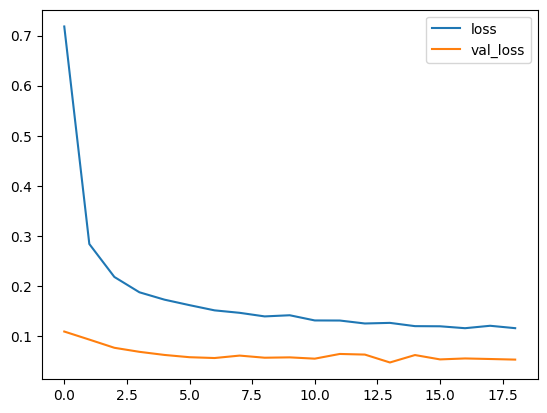

In [12]:
plt.plot(history.history['loss'], label='loss') # Plotando os valores de treino
plt.plot(history.history['val_loss'], label='val_loss') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

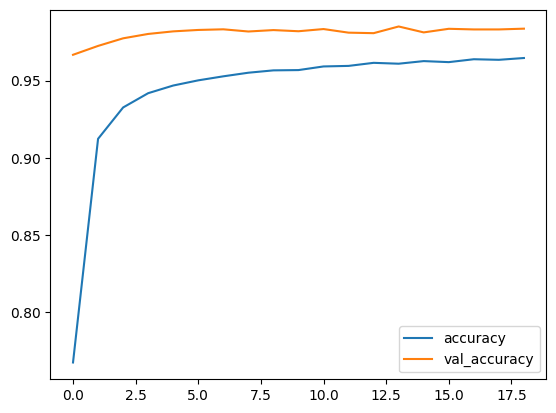

In [13]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy') # Plotando os valores de treino
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy') # Plotando os valores de validação
plt.legend() # Exibindo as legendas
plt.show() # Exibindo o gráfico

Nesse cenário, após a aplicação do pré processamento de Data Augmentation, os índicios de overfitting não aparecem mais, deixando assim o modelo pronto para ser utilizado com os dados reais.

### Fazendo o predict do modelo com uma amostra dos dados

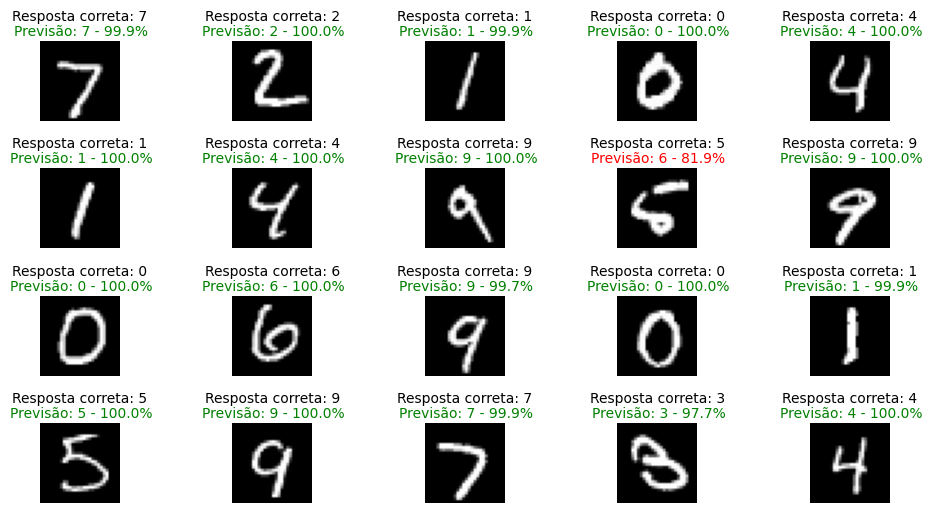

In [14]:
fig, axs = plt.subplots(figsize=(12,6), nrows=4, ncols=5) # Definindo o tamanho da figura para exibir os gráficos

for i, ax in enumerate(axs.flat): # Criando uma estrutura de repetição para percorrer cada valor de x e plotar em um gráfico
    ax.imshow(x_test[i], cmap='gray') # Plotando a imagem em um gráfico em escala de cinza
    ax.set_title(f'Resposta correta: {y_test[i]}', size=10, pad=15) # Definindo o título do gráfico
    ax.axis('off') # Desativando os títulos dos eixos
    pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0] # Armazenando a previsão do modelo em uma variável
    ax.text( # Adicionando um texto com a previsão do modelo
        14, # Definindo a posição horizontal
        -4, # Definindo a posição vertical
        f'Previsão: {pred.argmax()} - {pred.max():.1%}', # Definindo o conteúdo do texto
        color='green' if pred.argmax() == y_test[i] else 'red', # Definindo a cor do texto, variando de acordo com a previsão certa ou errada
        verticalalignment = 'center', # Definindo o alinhamento vertical
        horizontalalignment = 'center', # Definindo o alinhamento horizontal
    )

fig.subplots_adjust(hspace=0.6) # Ajustando o espaço entre cada subfigura

plt.show() # Exibindo os gráficos

### Testando o modelo em imagens criadas manualmente

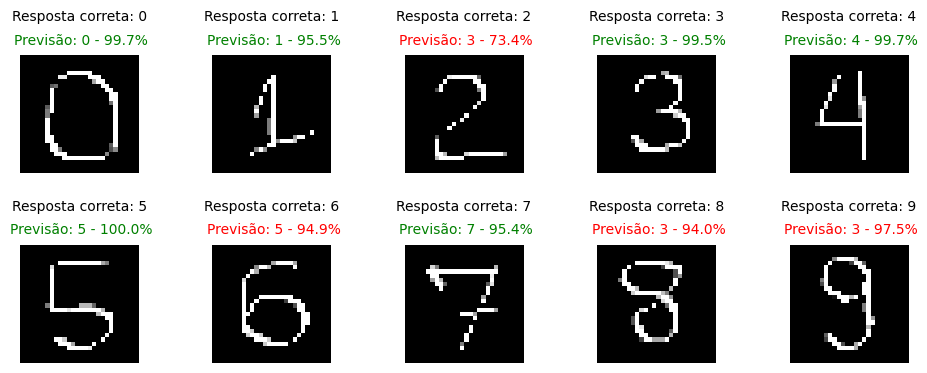

In [15]:
real_images_dir = Path('../images/real_images') # Armazenando em uma variável o caminho da pasta das imagens criadas manualmente

all_pred = {} # Criando um dicionário vazio para armazenar as previsões do modelo e poder verificar as probabilidades de cada resultado posteriormente

fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=5) # Definindo o tamanho da figura para exibir os gráficos

for i, (img, ax) in enumerate(zip(sorted(real_images_dir.glob('*.png')), axs.flat)): # Criando uma estrutura de repetição para percorrer as imagens criadas e plotar em um gráfico

    name = img.name.split('.')[0] # Armazenando em uma variável o nome da imagem com o número correto a partir do . como separador

    img = keras.preprocessing.image.load_img(
        img, target_size=(28, 28), color_mode='grayscale'
    ) # Ajustando a escala da imagem, pois o modelo foi treinado com imagens com 28 x 28 pixels, e as que fizemos possuem 128 x 128
    img_array = keras.preprocessing.image.img_to_array(img) # Convertendo a imagem para um array NumPy
    img_array = 255 - img_array # Invertendo as cores da imagem, pois o modelo foi treinado com imagens com fundo preto, e as que fizemos são com fundo branco
    img_array = tf.expand_dims(img_array, 0) # Adicionando uma dimensão extra

    pred = model.predict(img_array, verbose=0) # Armazenando o valor previsto em uma variável
    all_pred[name] = pred # Adicionando a previsão no dicionário criado anteriormente para isso

    ax.imshow(img_array[0], cmap='gray') # Plotando a imagem em um gráfico em escala de cinza
    ax.set_title(f'Resposta correta: {name}', size=10, pad=25) # Definindo o título do gráfico
    ax.axis('off') # Desativando os títulos dos eixos
    ax.text( # Adicionando um texto com a previsão do modelo
        14, # Definindo a posição horizontal
        -4, # Definindo a posição vertical
        f'Previsão: {pred.argmax()} - {pred.max():.1%}', # Definindo o conteúdo do texto
        color='green' if str(pred.argmax()) == name else 'red', # Definindo a cor do texto, variando de acordo com a previsão certa ou errada
        verticalalignment = 'center', # Definindo o alinhamento vertical
        horizontalalignment = 'center', # Definindo o alinhamento horizontal
    )

fig.subplots_adjust(hspace=0.6) # Ajustando o espaço entre cada subfigura

plt.show() # Exibindo os gráficos


### Verificando as probabilidades de resultados para cada imagem

In [16]:
formatted_pred = { # Criando um dicionário para formatar os valores 
    key: np.array([['{:.1f}%'.format(x * 100) for x in row] for row in value]) 
    for key, value in all_pred.items()
}

for key, value in formatted_pred.items(): # Criando uma estrutura de repetição para printar os resultados de chave e valor das previsões
    print(f'{key}: {value}')

0: [['99.7%' '0.0%' '0.1%' '0.0%' '0.0%' '0.1%' '0.0%' '0.0%' '0.0%' '0.1%']]
1: [['0.0%' '95.5%' '0.7%' '1.0%' '0.9%' '0.1%' '0.0%' '1.7%' '0.0%' '0.1%']]
2: [['0.0%' '0.0%' '26.6%' '73.4%' '0.0%' '0.0%' '0.0%' '0.0%' '0.0%' '0.0%']]
3: [['0.0%' '0.0%' '0.2%' '99.5%' '0.0%' '0.3%' '0.0%' '0.0%' '0.0%' '0.0%']]
4: [['0.0%' '0.0%' '0.1%' '0.0%' '99.7%' '0.0%' '0.0%' '0.1%' '0.0%' '0.1%']]
5: [['0.0%' '0.0%' '0.0%' '0.0%' '0.0%' '100.0%' '0.0%' '0.0%' '0.0%' '0.0%']]
6: [['2.2%' '0.0%' '0.0%' '0.0%' '0.0%' '94.9%' '2.8%' '0.0%' '0.0%' '0.0%']]
7: [['0.0%' '0.0%' '0.0%' '4.5%' '0.0%' '0.0%' '0.0%' '95.4%' '0.0%' '0.0%']]
8: [['0.0%' '0.0%' '3.6%' '94.0%' '0.0%' '0.0%' '0.0%' '0.3%' '1.9%' '0.2%']]
9: [['0.0%' '0.0%' '2.0%' '97.5%' '0.0%' '0.0%' '0.0%' '0.0%' '0.0%' '0.4%']]
